# Data Extraction

In [ ]:
!pip install -q ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.1/562.1 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.1/203.1 kB 24.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir data
!unzip -q /content/drive/MyDrive/monkey/data.zip train_annotation.json val_annotation.json -d data/
!unzip -q /content/drive/MyDrive/monkey/data.zip train/* val/* -d data/

# Imports

In [ ]:
import os
import cv2
import json
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# YOLO V8 CONFIG FILES 

In [ ]:
yaml_content = """
# Ultralytics YOLO 🚀, AGPL-3.0 license
# YOLOv8-pose keypoints/pose estimation model. For Usage examples see https://docs.ultralytics.com/tasks/pose

# Parameters
nc: 1  # number of classes
kpt_shape: [17, 2]  # number of keypoints, number of dims (2 for x,y or 3 for x,y,visible)
scales: # model compound scaling constants, i.e. 'model=yolov8n-pose.yaml' will call yolov8-pose.yaml with scale 'n'
  # [depth, width, max_channels]
  
  n: [0.33, 0.25, 1024]
  s: [0.33, 0.50, 1024]
  m: [0.67, 0.75, 768]
  l: [1.00, 1.00, 512]
  x: [1.00, 1.25, 512]

# YOLOv8.0n backbone
backbone:
  # [from, repeats, module, args]
  - [-1, 1, Conv, [64, 3, 2]]  # 0-P1/2
  - [-1, 1, Conv, [128, 3, 2]]  # 1-P2/4
  - [-1, 3, C2f, [128, True]]
  - [-1, 1, Conv, [256, 3, 2]]  # 3-P3/8
  - [-1, 6, C2f, [256, True]]
  - [-1, 1, Conv, [512, 3, 2]]  # 5-P4/16
  - [-1, 6, C2f, [512, True]]
  - [-1, 1, Conv, [1024, 3, 2]]  # 7-P5/32
  - [-1, 3, C2f, [1024, True]]
  - [-1, 1, SPPF, [1024, 5]]  # 9

# YOLOv8.0n head
head:
  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 6], 1, Concat, [1]]  # cat backbone P4
  - [-1, 3, C2f, [512]]  # 12

  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 4], 1, Concat, [1]]  # cat backbone P3
  - [-1, 3, C2f, [256]]  # 15 (P3/8-small)

  - [-1, 1, Conv, [256, 3, 2]]
  - [[-1, 12], 1, Concat, [1]]  # cat head P4
  - [-1, 3, C2f, [512]]  # 18 (P4/16-medium)

  - [-1, 1, Conv, [512, 3, 2]]
  - [[-1, 9], 1, Concat, [1]]  # cat head P5
  - [-1, 3, C2f, [1024]]  # 21 (P5/32-large)

  - [[15, 18, 21], 1, Pose, [nc, kpt_shape]]  # Pose(P3, P4, P5)
"""

with open("yolov8_pose_custom.yaml", "w") as file:
    file.write(yaml_content)

In [ ]:
yaml_content = """
# Ultralytics YOLO 🚀, AGPL-3.0 license
# COCO8-pose dataset (first 8 images from COCO train2017) by Ultralytics
# Example usage: yolo train data=coco8-pose.yaml
# parent
# ├── ultralytics
# └── datasets
#     └── coco8-pose  ← downloads here (1 MB)


# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: data/  # dataset root dir
train: train/images  # train images (relative to 'path') 4 images
val: val/images  # val images (relative to 'path') 4 images

# Keypoints
kpt_shape: [17,2]  # number of keypoints, number of dims (2 for x,y or 3 for x,y,visible)

# Classes
names:
  0: monkey
"""
with open("dataset.yaml", "w") as file:
    file.write(yaml_content)

# Config Setup

In [ ]:
class config:
    RANDOM_STATE = 12
    BATCH_SIZE = 256
    NUM_WORKERS = 12
    IMAGE_HEIGHT = 640
    IMAGE_WIDTH = 640
    LEARNING_RATE = 1e-4
    EPOCHS = 3

# Data Loading and Processing

In [ ]:
!mkdir /content/data/train/labels
!mkdir /content/data/val/labels

In [ ]:
train_annot = json.load(open("data/train_annotation.json"))
train_df = pd.DataFrame(train_annot["data"])

val_annot = json.load(open("data/val_annotation.json"))
val_df = pd.DataFrame(val_annot["data"])

os.rename("data/train/train", "data/train/images")
os.rename("data/val/val", "data/val/images")

train_df["file"] = "data/train/images/" + train_df["file"]
val_df["file"] = "data/val/images/" + val_df["file"]

In [ ]:
for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    bbox = row["bbox"]
    values = row['landmarks']
    image_path = row["file"]
    img = cv2.imread(image_path)
    height, width, _ = img.shape
    bbox = [round(bbox[0]/width, 2 ), round(bbox[1]/height, 2 ), round(bbox[2]/width, 2 ), round(bbox[3]/height, 2 )]

    for i in range(len(values)):
        if i % 2 == 0:
            # x coordinate
            values[i] = round(values[i]/ width, 2)
        else:
            # y coordinate
            values[i] = round(values[i]/ height, 2 )
    
    values_str = ' '.join(str(v) for v in bbox) + ' ' +  ' '.join(str(v) for v in values)
    output =  "0 " + values_str
    out_path = "data/train/labels/" + row["file"].split(".jpg")[0].split("/")[-1] + ".txt"
    with open(out_path , 'w') as f:
        f.write(output)

for index, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
    bbox = row["bbox"]
    values = row['landmarks']
    image_path = row["file"]
    img = cv2.imread(image_path)
    height, width, _ = img.shape
    bbox = [round(bbox[0]/width, 2 ), round(bbox[1]/height, 2 ), round(bbox[2]/width, 2 ), round(bbox[3]/height, 2 )]

    for i in range(len(values)):
        if i % 2 == 0:
            # x coordinate
            values[i] = round(values[i]/ width, 2)
        else:
            # y coordinate
            values[i] = round(values[i]/ height, 2 )
    
    values_str = ' '.join(str(v) for v in bbox) + ' ' +  ' '.join(str(v) for v in values)
    output =  "0 " + values_str
    out_path = "data/val/labels/" + row["file"].split(".jpg")[0].split("/")[-1] + ".txt"
    with open(out_path , 'w') as f:
        f.write(output)

  0%|          | 0/66917 [00:00<?, ?it/s]

  0%|          | 0/22306 [00:00<?, ?it/s]

In [ ]:
!mkdir datasets
!mv data datasets

train_df["file"] = "datasets/" + train_df["file"]
val_df["file"] = "datasets/" + val_df["file"]

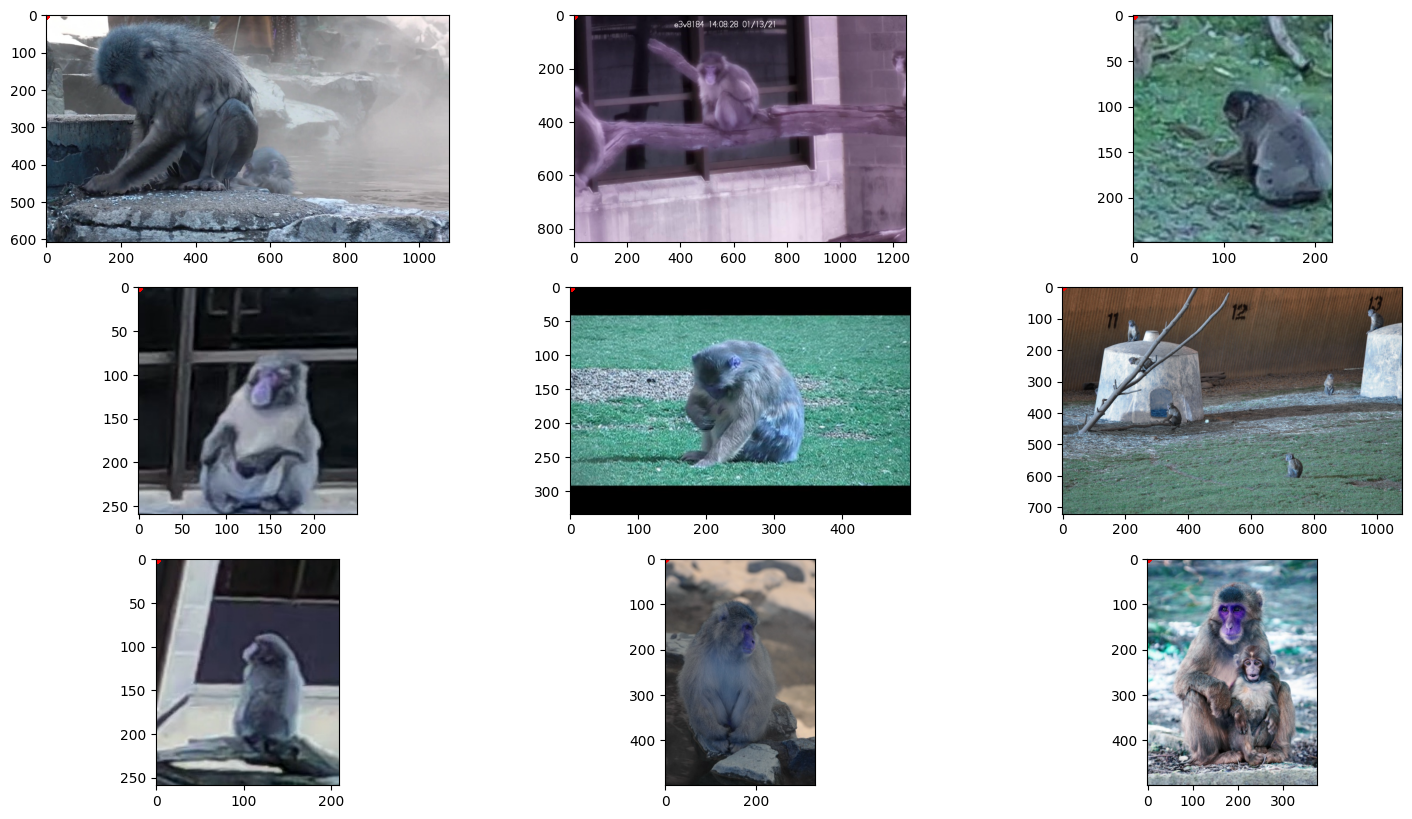

In [ ]:
fig, axs = plt.subplots(3,3, figsize = (18, 10))

paths = [ train_df.iloc[i]["file"] for i in range(9)]
landmarks = [train_df.iloc[i]["landmarks"] for i in range(9)]
landmarks = [np.array(landmark).reshape(-1, 2) for landmark in landmarks]

# Flatten the axes array for easy indexing
axs = axs.flatten()

for i in range(len(paths)):
    image = cv2.imread(paths[i])
    landmark = landmarks[i]
    
    # Reshape the landmarks into an array of shape (17, 2)
    landmark = np.array(landmark).reshape(-1, 2)

    # Plot the image
    axs[i].imshow(image)

    # Plot the landmarks
    x = landmark[:, 0]
    y = landmark[:, 1]
    axs[i].scatter(x, y, s=10, c='red', marker='o')

# Hide the empty subplots
for i in range(len(paths), len(axs)):
    axs[i].axis('off')

# Show the plot
plt.show()

# Modelling 

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8_pose_custom.yaml').load('yolov8x-pose.pt')

# Train the model
model.train(data='dataset.yaml', 
            epochs=config.EPOCHS, 
            imgsz=config.IMAGE_HEIGHT, 
            batch = config.BATCH_SIZE, 
            lr0 = config.LEARNING_RATE,
            optimizer = "AdamW")

WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295

KeyboardInterrupt: ignored

## Model Evaluation


In [ ]:
model = YOLO("runs/pose/train/weights/best.pt")

In [ ]:
preds = []
labels = []
for i in tqdm(range(len(val_df))):
    row = val_df.iloc[i]
    landmarks = row["landmarks"]
    out = model(row["file"], verbose = False)
    if out[0].keypoints.cpu().numpy().tolist() == []:
        labels.append(landmarks)
        preds.append(landmarks)
    elif out[0].keypoints.cpu().numpy().shape[0] == 1:
        labels.append(landmarks)
        preds.append(out[0].keypoints.cpu().numpy()[0].flatten().tolist())
    else:
        min = float("inf")
        for pred_landmark in out[0].keypoints.cpu().numpy():
            if abs(np.array(pred_landmark.flatten() - landmarks).sum()) < min:
                min =  abs(np.array(pred_landmark.flatten() - landmarks).sum())
                final_pred = pred_landmark.flatten() 
        labels.append(landmarks)
        preds.append(final_pred)
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/22306 [00:00<?, ?it/s]

## Evaluation Metrics

In [ ]:
def mean_squared_error(gt_labels, pred_labels):
    return np.mean(np.square(gt_labels - pred_labels)) / 34

def mean_absolute_error(gt_labels, pred_labels):
    return np.mean(np.abs(gt_labels - pred_labels)) / 34

def percentage_of_correct_keypoints(gt_labels, pred_labels, threshold):
    batch_size = gt_labels.shape[0]
    n_keypoints = gt_labels.shape[1] // 2

    gt_keypoints = gt_labels.reshape(batch_size, n_keypoints, 2)
    pred_keypoints = pred_labels.reshape(batch_size, n_keypoints, 2)

    distances = np.sqrt(np.sum((gt_keypoints - pred_keypoints)**2, axis=-1))
    correct_keypoints = (distances <= threshold).sum()

    return correct_keypoints / (batch_size * n_keypoints)

def mean_per_joint_position_error(gt_labels, pred_labels):
    batch_size = gt_labels.shape[0]
    n_keypoints = gt_labels.shape[1] // 2

    gt_keypoints = gt_labels.reshape(batch_size, n_keypoints, 2)
    pred_keypoints = pred_labels.reshape(batch_size, n_keypoints, 2)

    distances = np.sqrt(np.sum((gt_keypoints - pred_keypoints)**2, axis=-1))
    mean_distances = distances.mean()

    return mean_distances


In [ ]:
print("Starting Model Evaluation!")

print()
print("Mean Absolute Error = ", mean_absolute_error(labels, preds))
print("Mean Squared Error = ", mean_squared_error(labels, preds))
print("Mean Per Joint Position Error = ", mean_per_joint_position_error(labels, preds))
print("Percentage of Correct Keypoints at 5% Threshold = ", percentage_of_correct_keypoints(labels, preds , 0.05 * config.IMAGE_HEIGHT)*100)
print("Percentage of Correct Keypoints at 10% Threshold = ", percentage_of_correct_keypoints(labels, preds , 0.10 * config.IMAGE_HEIGHT)*100)

Starting Model Evaluation!

Mean Absolute Error =  0.024850672056590518
Mean Squared Error =  3.6357816145484123
Mean Per Joint Position Error =  67.29671870669716
Percentage of Correct Keypoints at 5% Threshold =  44.35472386749015
Percentage of Correct Keypoints at 10% Threshold =  64.32771979050743
